## Домашнее задание 4 - одномерный клеточный автомат

Для реализации одномерного клеточного автомата (https://ru.wikipedia.org/wiki/Правило_110) с периодическими граничными условиями мы воспользуемся распараллеливанием с помощью MPI. Для корректного распараллеливания мы будем использовать так называемые «клетки-призраки» (см. Рисунок ниже).

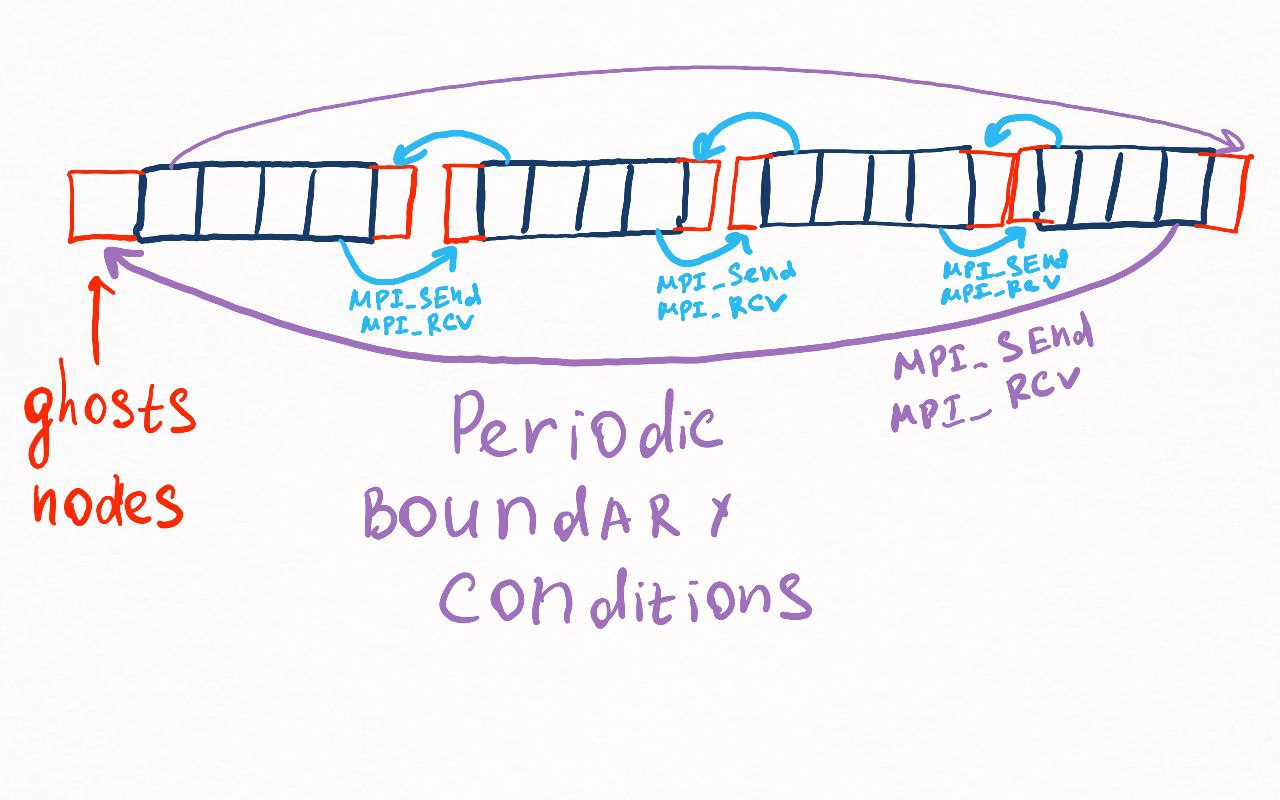

автор кода и рисунка Денис Тауренис (вроде)

Код получит правило в формате числа от 0 до 255. Например, мы хотим использовать правило 130. $130 = 10000010_2$. Это означает, что $000 = 0; 001 = 1; 010 = 0$ ...(все нули)... $111 = 1$. Начальные условия будут выбраны случайным образом.

In [21]:
%%writefile cellular_periodic.c

#include <mpi.h>
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <string.h>

//Length of the stirng
static const int N = 100;//40000000;

//Number of iterations
static const int Nit = 100;//10;

int main(int argc, char ** argv)
{
    int r = atoi(argv[1]);
    int rule[] = {0, 1, 0, 0, 1, 0, 1, 1};
    int r1 = r;
    for (int i = 7; i>=0; i--){
        rule[i] = r1 / (1 << i);
        r1 -= (r1/(1 << i)) * (1 << i);
    }

    int psize;
    int prank;
    MPI_Status status;

    int ierr;

    ierr = MPI_Init(&argc, &argv);
    ierr = MPI_Comm_rank(MPI_COMM_WORLD, &prank);
    ierr = MPI_Comm_size(MPI_COMM_WORLD, &psize);

    MPI_File_delete(argv[2], MPI_INFO_NULL);

    MPI_Barrier(MPI_COMM_WORLD);
    double t1, t2;
    t1 = MPI_Wtime();

    srand (time(NULL) +  prank);

    MPI_Request request;
    MPI_File fh;
    int rc = MPI_File_open(MPI_COMM_WORLD, argv[2], MPI_MODE_CREATE|MPI_MODE_EXCL|MPI_MODE_WRONLY, MPI_INFO_NULL, &fh);
    int sizeRank = N/psize + ((prank+1)/(N%psize+1) == 0 ? 1 : 0);

    //Size of the chunk corresponded to the thread
    MPI_Offset offset = sizeRank*prank;
    int sizeRow = sizeRank + 2;
    int charSize = sizeRank + (prank==(psize-1));

    char* buf = (char*)malloc(charSize * sizeof(char));
    if (prank == (psize-1))
        buf[charSize-1] = '\n';
    int* row = (int*)malloc(sizeRow * sizeof(int));
    for(int i = 1; i < sizeRow -1; i++)
        row[i] = rand()%2;

    int* rowChanged = (int*)malloc(sizeRow * sizeof(int));

    
    for (int j = 0; j<Nit; j++){
        if (psize>1)
        {
            //Boundary conditions
            if (prank == 0){
                MPI_Isend(row+1, 1, MPI_INT, psize-1, 1, MPI_COMM_WORLD, &request);
                MPI_Isend(row+sizeRow-2, 1, MPI_INT, 1, 0, MPI_COMM_WORLD, &request);
            } else if (prank == psize - 1){
                MPI_Isend(row+1, 1, MPI_INT, psize-2, 1, MPI_COMM_WORLD, &request);
                MPI_Isend(row+sizeRow-2, 1, MPI_INT, 0, 0, MPI_COMM_WORLD, &request);
            } else{
                MPI_Isend(row+1, 1, MPI_INT, prank-1, 1, MPI_COMM_WORLD, &request);
                MPI_Isend(row+sizeRow-2, 1, MPI_INT, prank + 1, 0, MPI_COMM_WORLD, &request);
            }
            MPI_Recv(row, 1, MPI_INT, MPI_ANY_SOURCE, 0, MPI_COMM_WORLD, &status);
            MPI_Recv(row + sizeRow - 1, 1, MPI_INT, MPI_ANY_SOURCE, 1, MPI_COMM_WORLD, &status);

            ierr =  MPI_Barrier(MPI_COMM_WORLD);
        }
        else{
            row[0] = row[sizeRow-2];
            row[sizeRow-1] = row[1];
        }

        //On step of the iteration with respect to the chink of the thread
        for (int i = 1; i < sizeRow - 1; i++){
            rowChanged[i] = rule[4 * row[i-1] + 2 * row[i] + row[i+1]];
        }
        for (int i = 1; i < sizeRow - 1; i++){
            row[i] = rowChanged[i];
            buf[i-1] = rowChanged[i] +'0';
        }
        
        //write to file
        MPI_File_write_at(fh, offset, buf, charSize, MPI_CHAR, MPI_STATUS_IGNORE);
        offset+=N+1;
            
        ierr =  MPI_Barrier(MPI_COMM_WORLD);
    }
    free(row);
    free(buf);
    free(rowChanged);
    MPI_File_close(&fh);
    t2 = MPI_Wtime();
    if (prank == 0)
        printf("MPI_Wtime: %1.4f\n", t2-t1);

    ierr = MPI_Finalize();    
    return 0;
}

Overwriting cellular_periodic.c


In [22]:
!mpicc cellular_periodic.c

Let's see results for rules $120, 140,$ and $30$. These are presented in the images below.

In [23]:
!mpirun -n 1 ./a.out 30 30.txt

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
MPI_Wtime: 0.0026


In [24]:
!mpirun -n 2 ./a.out 120 120.txt

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
MPI_Wtime: 0.0013


In [25]:
!mpirun -n 4 ./a.out 110 110.txt

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
MPI_Wtime: 0.0050


In [26]:
def open_data(file):
    filename = open(file, "r")
    data = []
    gr = filename.readline().strip()
    while gr:
        gr = list(map(int,str(gr)))
        data.append(gr)
        gr = filename.readline().strip()
    data = np.array(data)
    return data

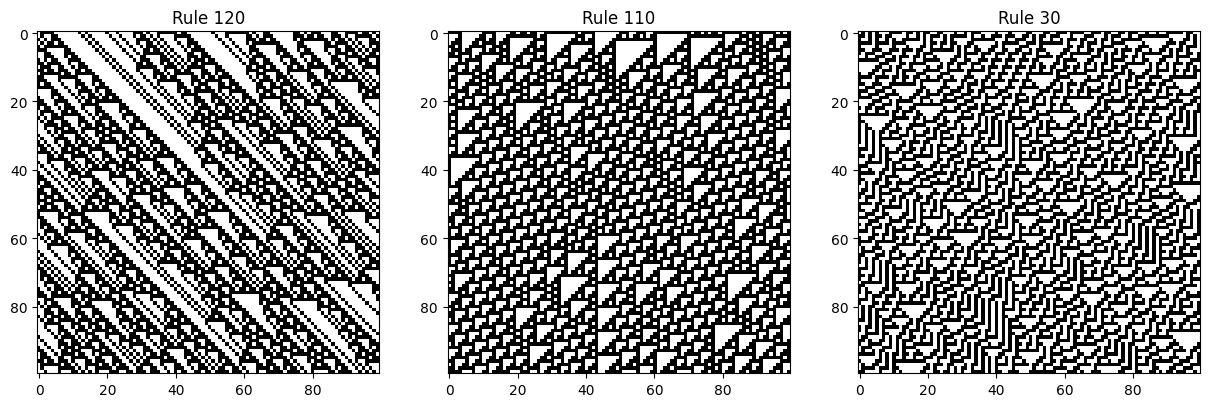

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize = (15, 10))

data = open_data("120.txt")
ax[0].imshow(data, cmap='bone_r')
ax[0].set_title("Rule 120")

data = open_data("110.txt")
ax[1].imshow(data, cmap='bone_r')
ax[1].set_title("Rule 110")

data = open_data("30.txt")
ax[2].set_title("Rule 30")
ax[2].imshow(data, cmap='bone_r')

plt.show()

## Задания

1. Проверить, что код, представленный выше работает на вашем компьютере
2. Измерить время расчета на 1, 2, 4 mpi процессах. Виден ли прирост производительности, при использовании большего числа ядер? Что будет если поварьировать длину массива (параметр **N**)?
3. Попробовать реализовать клеточный автомат на Python. Получится ли сделать код быстрее данной реализации в C? Можно писать код, используя любые инструменты (не только те, что были представлены на занятиях). Можно изпользовать логику, отличную от представленной в сишной реализации.